In [1]:
# Readlines into list of tweets and labels
f = open('tweets.txt', encoding="utf8")
raw_tweets = f.readlines()
f.close()

f = open('labels.txt')
raw_labels = f.readlines()
f.close()

# Create list of output targets
target_dataset = list()
for label in raw_labels:
    if label == '1\n':
        target_dataset.append(1)
    else:
        target_dataset.append(0)

In [2]:
import tensorflow as tf

def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 240)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    y_batch = tf.convert_to_tensor(y_batch, dtype=tf.int64)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [3]:
X_batch, y_batch = preprocess(raw_tweets, target_dataset)

In [4]:
X_test, X_train_full = X_batch[:4000], X_batch[4000:]
y_test, y_train_full = y_batch[:4000], y_batch[4000:]

In [5]:
from collections import Counter
import numpy

vocabulary = Counter()
for review in X_train_full:
    vocabulary.update(list(review.numpy()))

In [6]:
vocab_size = 15000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]
]

In [7]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [8]:
def encode_words(dataset_input):
    return table.lookup(dataset_input)

In [9]:
X_valid, X_train = encode_words(X_train_full[:4000]), encode_words(X_train_full[4000:])
y_valid, y_train = y_train_full[:4000], y_train_full[4000:]

In [10]:
from tensorflow import keras

embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, mask_zero=True, input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])

In [11]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [12]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_valid, y_valid))

Train on 20282 samples, validate on 4000 samples
Epoch 1/5
20282/20282 [==============================] - 86s 4ms/sample - loss: 0.2165 - accuracy: 0.9050 - val_loss: 0.1566 - val_accuracy: 0.9375
Epoch 2/5
20282/20282 [==============================] - 77s 4ms/sample - loss: 0.0654 - accuracy: 0.9768 - val_loss: 0.1680 - val_accuracy: 0.9358
Epoch 3/5
20282/20282 [==============================] - 78s 4ms/sample - loss: 0.0241 - accuracy: 0.9912 - val_loss: 0.1989 - val_accuracy: 0.9348
Epoch 4/5
20282/20282 [==============================] - 80s 4ms/sample - loss: 0.0122 - accuracy: 0.9959 - val_loss: 0.2680 - val_accuracy: 0.9352
Epoch 5/5
20282/20282 [==============================] - 82s 4ms/sample - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.3409 - val_accuracy: 0.9350


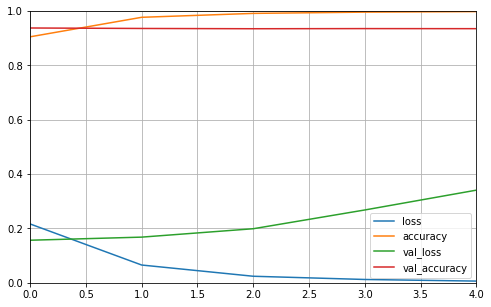

In [14]:
# Represent learning curves using pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [15]:
X_test_encoded = encode_words(X_test)

In [16]:
model.evaluate(X_test_encoded, y_test)

4000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.35482063677821135, 0.932]

In [17]:
X_new = X_test_encoded[:10]
y_proba = model.predict(X_new)
for i in range(len(y_proba)):
    print("Prediction: " + str(y_proba[i][0].round(2)) + "\nActual: " + str(y_test[i].numpy()) + "\n")

Prediction: 0.0
Actual: 0

Prediction: 1.0
Actual: 1

Prediction: 1.0
Actual: 1

Prediction: 1.0
Actual: 1

Prediction: 1.0
Actual: 1

Prediction: 0.0
Actual: 0

Prediction: 0.99
Actual: 0

Prediction: 0.0
Actual: 0

Prediction: 0.94
Actual: 0

Prediction: 1.0
Actual: 1

